# Introduction
This notebook is used as a introduction to propensity score matching. It uses the Simulated dataset . 
The main goal is to estimate the effect of a promotion (i.e. the customer used a promotion) on the final increase in the basket size compared to the historical basket size/average spend. 

The dataset helps illustrate how we could potentially assess the impact of a treatment in cases where we cannot perform a RCT (randomised controlled testing) on the subjects.

1. <a href='#Key-points'>Key points and variables</a>
2. <a href='#Data-Preparation'>Data Preparation</a>
3. <a href='#Matching-Implementation'>Matching implementation</a>
4. <a href='#Matching-Review'>Matching Review</a>
5. <a href='#Average-Treatement-effect'>Average Treatement Effect</a>

# Key points
In order to proceed to PSM (propensity score matching), the following key points are considered:
- Matching is used to create an artificial control group so then to estimate the impact of treatment.
- Dimensions:
    - X are the features available to match customers
    - T is the treatment; can be either 1 or 0. In this notebook the promotion is considered as T=1 (i.e. the customer got treated).
    - Y is the outcome variable i.e. is the basket size bigger than the average historcal basket size (0 or 1)
    
# Variables:
1. 'CustomerId' - represents a unique customer
2. 'Cust_Class' - represent the tier of customer subscription
3. 'Name' - Name of the customer (simulated)
4. 'Sex' - Sex of the customer (simulated)
5. 'Age' - Age of the customer
6. 'Usage_rank' - Rank of the customer in terms of historical engagement
7. 'Parch' - Number of linked associations with the customer
8. 'Ticket' - unique visit id of the customer
9. 'avg_spend' - average historical spend
10. 'promo' - promotion the customer used (treatment is derived from this)
11. 'city' - city the customer resides.
12. 'treatment' - treated or not (0 or 1)

# Data Preparation

In [76]:
import math
import pandas as pd

def perform_match_exact(row, df , *args):
    # row is the the item that we want to match
    # df is the source Pandas dataframe that we want to match it with other items
    # print('Start matching')
    sub_set = df
    
    for arg in args:
        sub_set = sub_set.loc[sub_set[arg] == row[arg]]
        # print(sub_set)
        
    return sub_set.index


def logit(p):
    logit_value = math.log(p / (1-p))
    return logit_value

def hasAccept(x):
    if pd.isna(x):
        return 0
    else:
        return 1
    
def cohenD (tmp, metricName):
    treated_metric = tmp[tmp.treatment == 1][metricName]
    untreated_metric = tmp[tmp.treatment == 0][metricName]
    
    d = ( treated_metric.mean() - untreated_metric.mean() ) / math.sqrt(((treated_metric.count()-1)*treated_metric.std()**2 + (untreated_metric.count()-1)*untreated_metric.std()**2) / (treated_metric.count() + untreated_metric.count()-2))
    return d

In [77]:
from sklearn.linear_model import LogisticRegression as lr

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics

In [78]:
# Enabled to remove warnings for demo purposes.
import warnings
warnings.filterwarnings('ignore')

In [79]:
#from functions import *
import math
import numpy as np
import pandas as pd
# import scipy.stats as stats
import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(16,10)}, font_scale=1.3)

In [80]:
import os
os.getcwd()

'/Users/s0g06w1/Documents/Causal Inference/Tutorial/Matching Tutorial'

In [23]:
df = pd.read_csv('data/train1.csv')
# Elements are dropped for simplicity.
df = df[~df.Age.isna()]
df = df[~df.city.isna()]
df = df.reset_index()
y = df[['Accepted']]
df = df.drop(columns = ['Accepted'])

Create an artificial treatment effect. It is based on the condition that a customer has a promotion (1) or not (0). The 'hasAccept' function is defined above.

In [86]:
df['treatment'] = df.promo.apply(hasAccept)

There is high correlation between treatment (i.e. promo) and Cust_Class.
This is desirable in this case as it plays the role of the systematic factor affecting the treatment.
In a different context this could be a landing page on site that only specific visitors see.

In [25]:
df.head(5)

,index,Unnamed: 0,CustomerId,Cust_Class,Name,Sex,Age,Usage_rank,Parch,Ticket,avg_spend,promo,city,treatment
0,0,0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,1,1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,2,2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,3,3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,4,4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [26]:
df = df.drop(columns = ['Unnamed: 0','index'])

In [27]:
df.head(5)

,CustomerId,Cust_Class,Name,Sex,Age,Usage_rank,Parch,Ticket,avg_spend,promo,city,treatment
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [81]:
df.columns

Index(['CustomerId', 'Cust_Class', 'Name', 'Sex', 'Age', 'Usage_rank', 'Parch',
       'Ticket', 'avg_spend', 'promo', 'city', 'treatment'],
      dtype='object')

In [28]:
pd.pivot_table(df[['treatment','Cust_Class','CustomerId']], \
               values = 'CustomerId', index = 'treatment', columns = 'Cust_Class',\
               aggfunc= np.count_nonzero)

Cust_Class,1,2,3
treatment,,,
0,26,158,345
1,158,15,10


Keeping only specific variables.
We should account for all variables that affect the treatment variable (i.e. promo).

In [29]:
df_data = df[['treatment','Sex','Age','Usage_rank','Parch','city', 'Cust_Class', 'avg_spend']]

In [30]:
T = df_data.treatment
X = df_data.loc[:,df_data.columns !='treatment']

In [31]:
X_encoded = pd.get_dummies(X, columns = ['Sex','city', 'Cust_Class'], \
                           prefix = {'Sex':'sex', 'city' : 'city', 'Cust_Class' : 'class'}, drop_first=False)

In [32]:
X_encoded

,Age,Usage_rank,Parch,avg_spend,sex_female,sex_male,city_C,city_Q,city_S,class_1,class_2,class_3
0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0
2,26.0,0,0,7.9250,1,0,0,0,1,0,0,1
3,35.0,1,0,53.1000,1,0,0,0,1,1,0,0
4,35.0,0,0,8.0500,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
707,39.0,0,5,29.1250,1,0,0,1,0,0,0,1
708,27.0,0,0,13.0000,0,1,0,0,1,0,1,0
709,19.0,0,0,30.0000,1,0,0,0,1,1,0,0
710,26.0,0,0,30.0000,0,1,1,0,0,1,0,0


In [33]:
# Design pipeline to build the treatment estimator
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_classifier', lr())
])

pipe.fit(X_encoded, T)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logistic_classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [34]:
predictions = pipe.predict_proba(X_encoded)
predictions_binary = pipe.predict(X_encoded)

In [35]:
print('Accuracy: {:.4f}\n'.format(metrics.accuracy_score(T, predictions_binary)))
print('Confusion matrix:\n{}\n'.format(metrics.confusion_matrix(T, predictions_binary)))
print('F1 score is: {:.4f}'.format(metrics.f1_score(T, predictions_binary)))

Accuracy: 0.9284

Confusion matrix:
[[503  26]
 [ 25 158]]

F1 score is: 0.8610


Convert propability to logit (based on the suggestion at https://youtu.be/gaUgW7NWai8?t=981)

In [36]:
predictions_logit = np.array([logit(xi) for xi in predictions[:,1]])

In [37]:
dw = pd.DataFrame()
dw['predictions'] = predictions[:,1]
dw['predictions_logit'] = predictions_logit
dw['treatment'] = T
dw.head(5)

,predictions,predictions_logit,treatment
0,0.021156,-3.834463,0
1,0.866755,1.872566,1
2,0.039982,-3.178512,0
3,0.895107,2.144005,1
4,0.019913,-3.896294,0


In [38]:
predictions

array([[0.9788443 , 0.0211557 ],
       [0.13324514, 0.86675486],
       [0.96001758, 0.03998242],
       ...,
       [0.06850969, 0.93149031],
       [0.15042495, 0.84957505],
       [0.98824114, 0.01175886]])

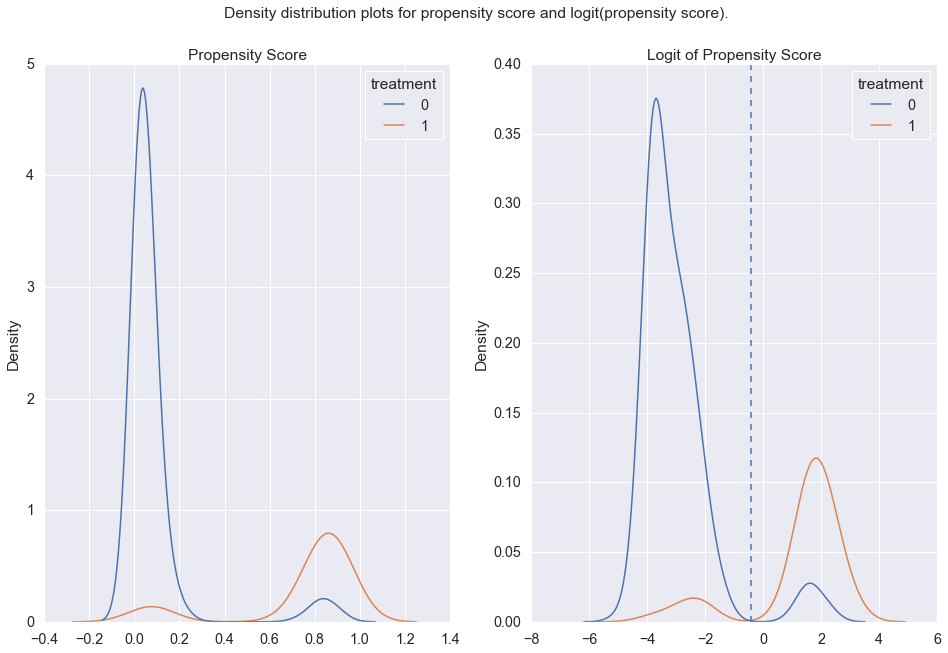

In [39]:
# Density distribution of propensity score (logic) broken down by treatment status
fig, ax = plt.subplots(1,2)
fig.suptitle('Density distribution plots for propensity score and logit(propensity score).')
sns.kdeplot(x = predictions[:,1], hue = T , ax = ax[0])
ax[0].set_title('Propensity Score')
sns.kdeplot(x = predictions_logit, hue = T , ax = ax[1])
ax[1].axvline(-0.4, ls='--')
ax[1].set_title('Logit of Propensity Score')
plt.show()

The graph on the right (logit_propensity_score) shows the density for each treatment situation. There is overlap accross the range of values (-6,5). However on the left of "-0.4" there are a lot more 0's than 1's. On the right side of "-0.4", the converse is true (a lot more 1's than 0's). 

This might affect later and how we will perform the matching so we can have balanced groups. In application, this means that for values X > -0.4, there are less untreated samples than treated. This will lead to untreated samples being used for more than one treated.

In [41]:
# Currently this does not affect the output as all observations fall within this range.
common_support = (predictions_logit > -10) & (predictions_logit < 10)

In [44]:
df_data.loc[:,'propensity_score'] = predictions[:,1]
df_data.loc[:,'propensity_score_logit'] = predictions_logit
df_data.loc[:,'outcome'] = y.Accepted

X_encoded.loc[:,'propensity_score'] = predictions[:,1]
X_encoded.loc[:,'propensity_score_logit'] = predictions_logit
X_encoded.loc[:,'outcome'] = y.Accepted
X_encoded.loc[:,'treatment'] = df_data.treatment

## Matching Implementation
Use Nearerst Neighbors to identify matching candidates. Then perform 1-to-1 matching by isolating/identifying groups of (T=1,T=0).
- Caliper: 25% of standart deviation of logit(propensity score) (This is sort of a thumb rule, but shouldn't be set in stone. This is no silver bullet)

In [45]:
caliper = np.std(df_data.propensity_score) * 0.25

print('\nCaliper (radius) is: {:.4f}\n'.format(caliper))

df_data = X_encoded

knn = NearestNeighbors(n_neighbors=10 , p = 2, radius=caliper)
knn.fit(df_data[['propensity_score_logit']].to_numpy())


Caliper (radius) is: 0.0889



NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=0.08890268148266277)

For each data point (based on the logit propensity score) obtain (at most) 10 nearest matches. This is regardless of their treatment status.

In [46]:
# Common support distances and indexes
distances , indexes = knn.kneighbors(
    df_data[['propensity_score_logit']].to_numpy(), \
    n_neighbors=10)

In [49]:
print('For item 0, the 5 closest distances are (first item is self):')
for ds in distances[0,0:5]:
    print('Element distance: {:5f}'.format(ds))
print('...')

For item 0, the 5 closest distances are (first item is self):
Element distance: 0.000000
Element distance: 0.000021
Element distance: 0.001106
Element distance: 0.004490
Element distance: 0.006540
...


In [50]:
print('For item 0, the 5 closest indexes are (first item is self):')
for idx in indexes[0,0:5]:
    print('Element index: {}'.format(idx))
print('...')

For item 0, the 5 closest indexes are (first item is self):
Element index: 0
Element index: 607
Element index: 539
Element index: 301
Element index: 590
...


In [51]:
def perfom_matching_v2(row, indexes, df_data):
    current_index = int(row['index']) # Obtain value from index-named column, not the actual DF index.
    prop_score_logit = row['propensity_score_logit']
    for idx in indexes[current_index,:]:
        if (current_index != idx) and (row.treatment == 1) and (df_data.loc[idx].treatment == 0):
            return int(idx)
         
df_data['matched_element'] = df_data.reset_index().apply(perfom_matching_v2, axis = 1, args = (indexes, df_data))

In [52]:
treated_with_match = ~df_data.matched_element.isna()

In [53]:
treated_matched_data = df_data[treated_with_match][df_data.columns]
treated_matched_data.head(3)

,Age,Usage_rank,Parch,avg_spend,sex_female,sex_male,city_C,city_Q,city_S,class_1,class_2,class_3,propensity_score,propensity_score_logit,outcome,treatment,matched_element
1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0,0.866755,1.872566,1,1,62.0
3,35.0,1,0,53.1000,1,0,0,0,1,1,0,0,0.895107,2.144005,1,1,306.0
5,54.0,0,0,51.8625,0,1,0,0,1,1,0,0,0.805110,1.418544,0,1,372.0


In [54]:
def obtain_match_details(row, all_data, attribute):
    return all_data.loc[row.matched_element][attribute]

untreated_matched_data = pd.DataFrame(data = treated_matched_data.matched_element)

attributes = ['Age', 'Usage_rank', 'Parch', 'avg_spend', 'sex_female', 'sex_male', 'city_C',
       'city_Q', 'city_S', 'class_1', 'class_2', 'class_3',
       'propensity_score', 'propensity_score_logit', 'outcome', 'treatment']
for attr in attributes:
    untreated_matched_data[attr] = untreated_matched_data.apply(obtain_match_details, axis = 1, all_data = df_data, attribute = attr)
    
untreated_matched_data = untreated_matched_data.set_index('matched_element')
untreated_matched_data.head(3)

,Age,Usage_rank,Parch,avg_spend,sex_female,sex_male,city_C,city_Q,city_S,class_1,class_2,class_3,propensity_score,propensity_score_logit,outcome,treatment
matched_element,,,,,,,,,,,,,,,,
62.0,28.0,0.0,0.0,47.10,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.866278,1.868444,0.0,0.0
306.0,35.0,1.0,0.0,52.00,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.895251,2.145533,1.0,0.0
372.0,56.0,0.0,0.0,26.55,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.805278,1.419613,0.0,0.0


In [55]:
untreated_matched_data.shape

(143, 16)

In [56]:
treated_matched_data.shape

(143, 17)

In [57]:
all_mached_data = pd.concat([treated_matched_data, untreated_matched_data])

In [58]:
all_mached_data.treatment.value_counts()

0.0    143
1.0    143
Name: treatment, dtype: int64

# Matching Review

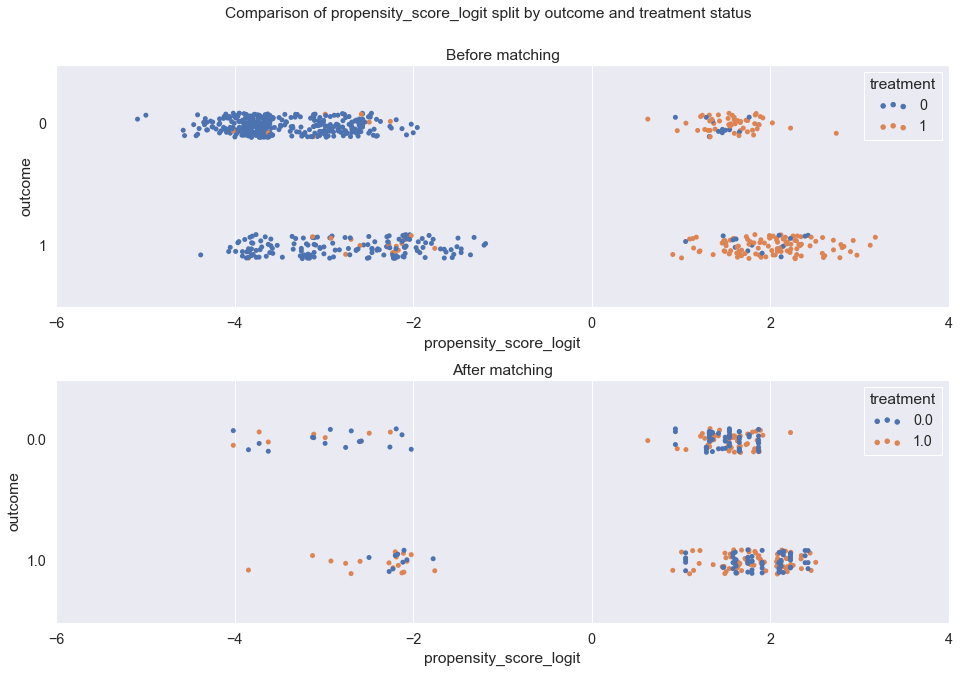

In [59]:
fig, ax = plt.subplots(2,1)
fig.suptitle('Comparison of {} split by outcome and treatment status'.format('propensity_score_logit'))
sns.stripplot(data = df_data, y = 'outcome', x = 'propensity_score_logit', hue = 'treatment', orient = 'h', ax = ax[0]).set(title = 'Before matching', xlim=(-6, 4))
sns.stripplot(data = all_mached_data, y = 'outcome', x = 'propensity_score_logit', hue = 'treatment', ax = ax[1] , orient = 'h').set(title = 'After matching', xlim=(-6, 4))
plt.subplots_adjust(hspace = 0.3)
plt.show()
fig.savefig("jitter_plot.png")

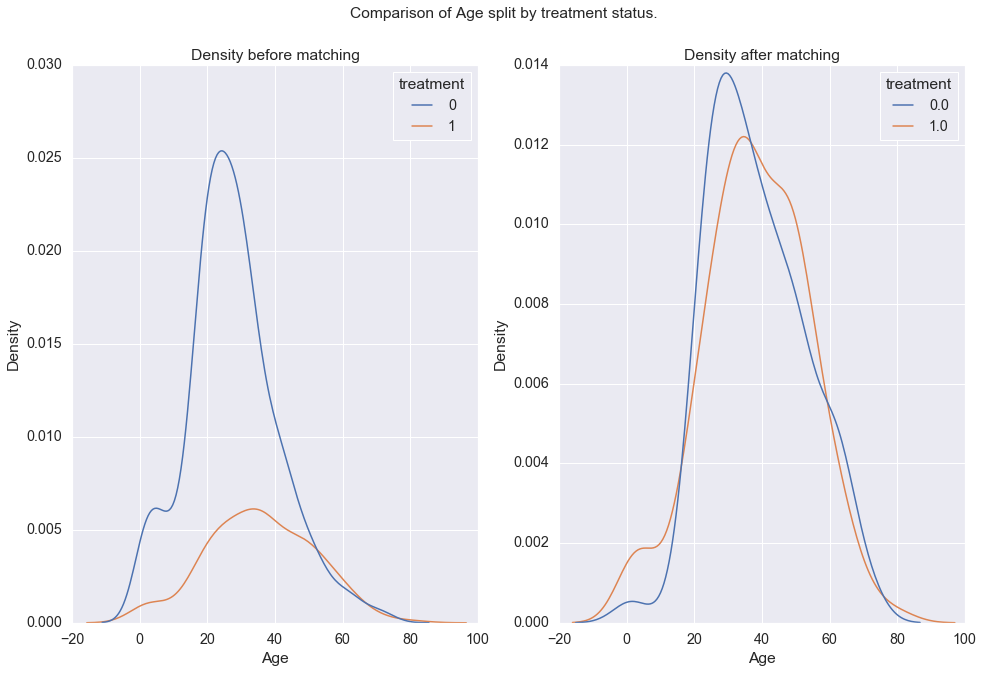

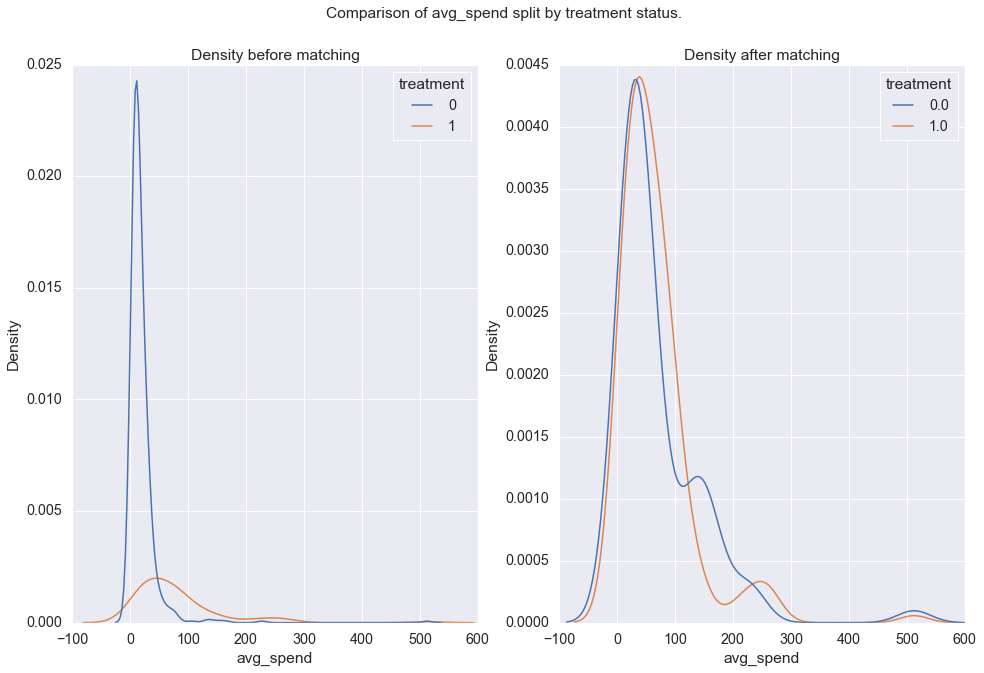

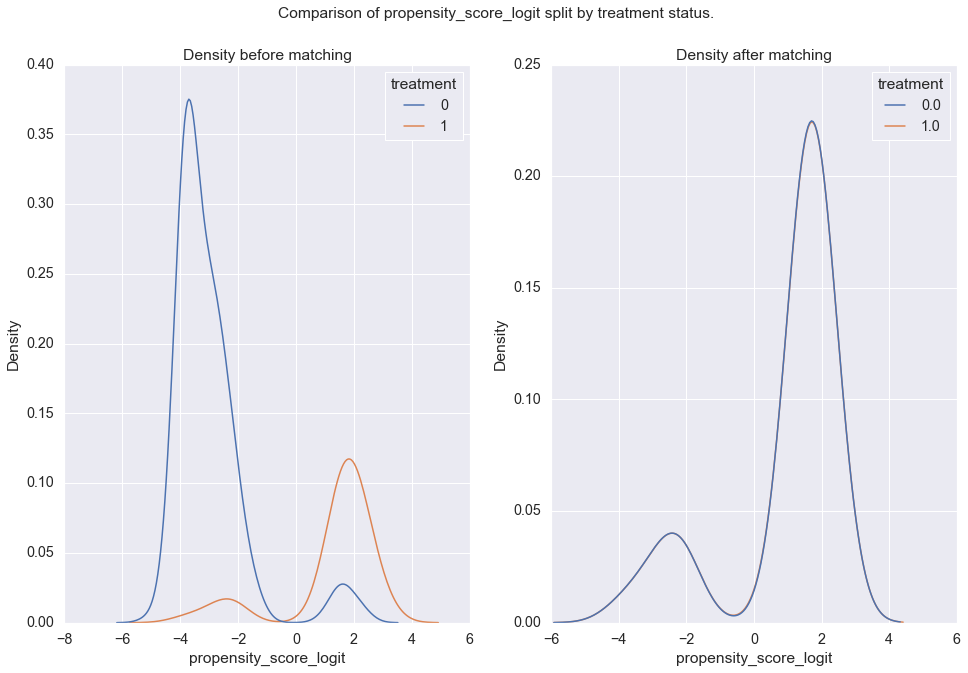

In [60]:
args = ['Age','avg_spend','propensity_score_logit']

def plot(arg):
    fig, ax = plt.subplots(1,2)
    fig.suptitle('Comparison of {} split by treatment status.'.format(arg))
    sns.kdeplot(data = df_data, x = arg, hue = 'treatment', ax = ax[0]).set(title='Density before matching')
    sns.kdeplot(data = all_mached_data, x = arg, hue = 'treatment',  ax = ax[1]).set(title='Density after matching')
    plt.show()
    fig.savefig("{}_comparison.png".format(arg))

for arg in args:
    plot(arg)

In [61]:
points_df = pd.merge(treated_matched_data[['Age','avg_spend','matched_element']]
                     , df_data[['Age','avg_spend']], how = 'right',  left_on = 'matched_element', right_index=True)

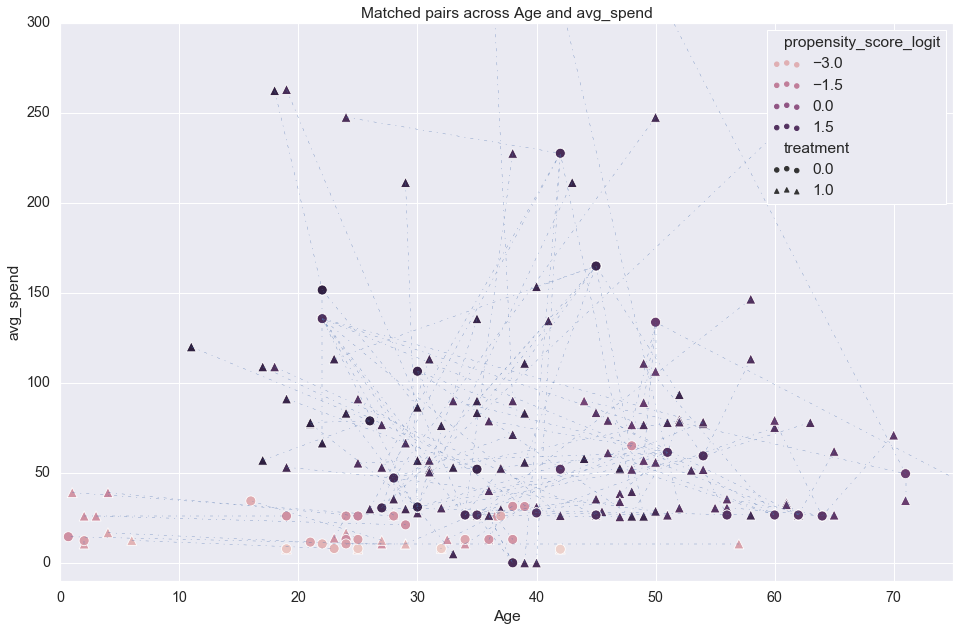

In [64]:
markers = {0: 'o', 1: '^'}

fig, ax = plt.subplots(1,1)

sns.scatterplot(data = all_mached_data, x = 'Age', y = 'avg_spend', style = 'treatment', s = 100, 
                markers = markers, hue = 'propensity_score_logit', ax = ax).\
    set(xlim=(0, 75), ylim=(-10, 300))
plt.title('Matched pairs across Age and avg_spend')

def add_lines(row):
    x1 = row.Age_x
    y1 = row.avg_spend_x
    x2 = row.Age_y
    y2 = row.avg_spend_y
    plt.plot([x1, x2], [y1, y2], linewidth=0.3, color = 'b', linestyle='dashdot' )

t = points_df.apply(add_lines, axis = 1)

fig.savefig("matching_overview.png")

In [65]:
data = []
cols = ['Age', 'Usage_rank', 'Parch', 'avg_spend', 'sex_female', 'sex_male', 'city_C',
       'city_Q', 'city_S', 'class_1', 'class_2', 'class_3']

# cols = ['Age','SibSp','Parch','Fare','sex_female','sex_male','embarked_C','embarked_Q','embarked_S']
for cl in cols:
    data.append([cl,'before', cohenD(df_data,cl)])
    data.append([cl,'after', cohenD(all_mached_data,cl)])

In [66]:
res = pd.DataFrame(data, columns=['variable','matching','effect_size'])

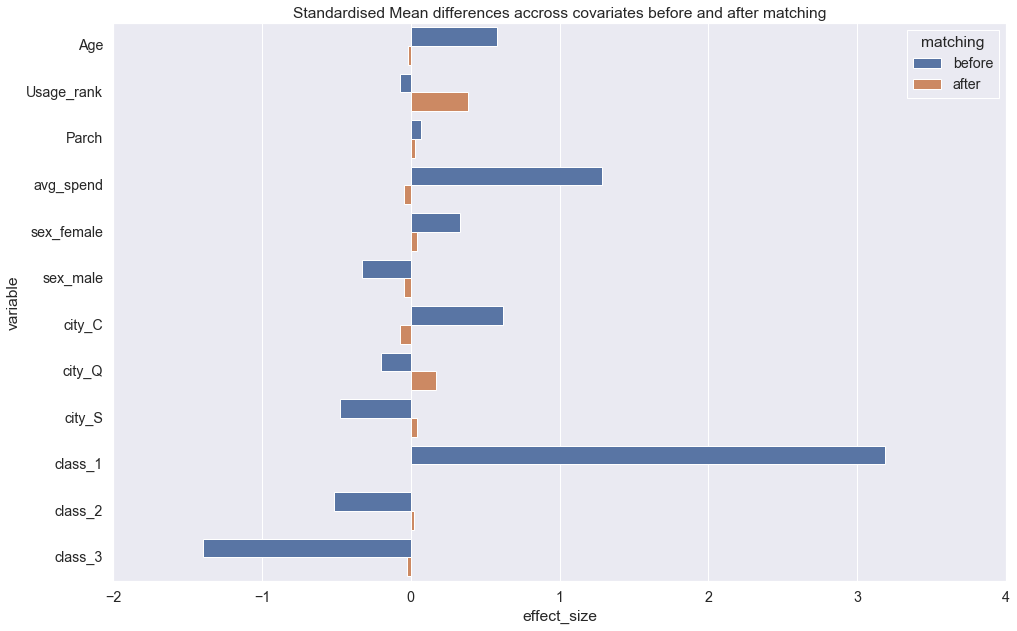

In [67]:
sn_plot = sns.barplot(data = res, y = 'variable', x = 'effect_size', hue = 'matching', orient='h')
sn_plot.set(title='Standardised Mean differences accross covariates before and after matching')
sn_plot.figure.savefig("standardised_mean_differences.png")

In [68]:
cols.append('treatment')

Overview before matching


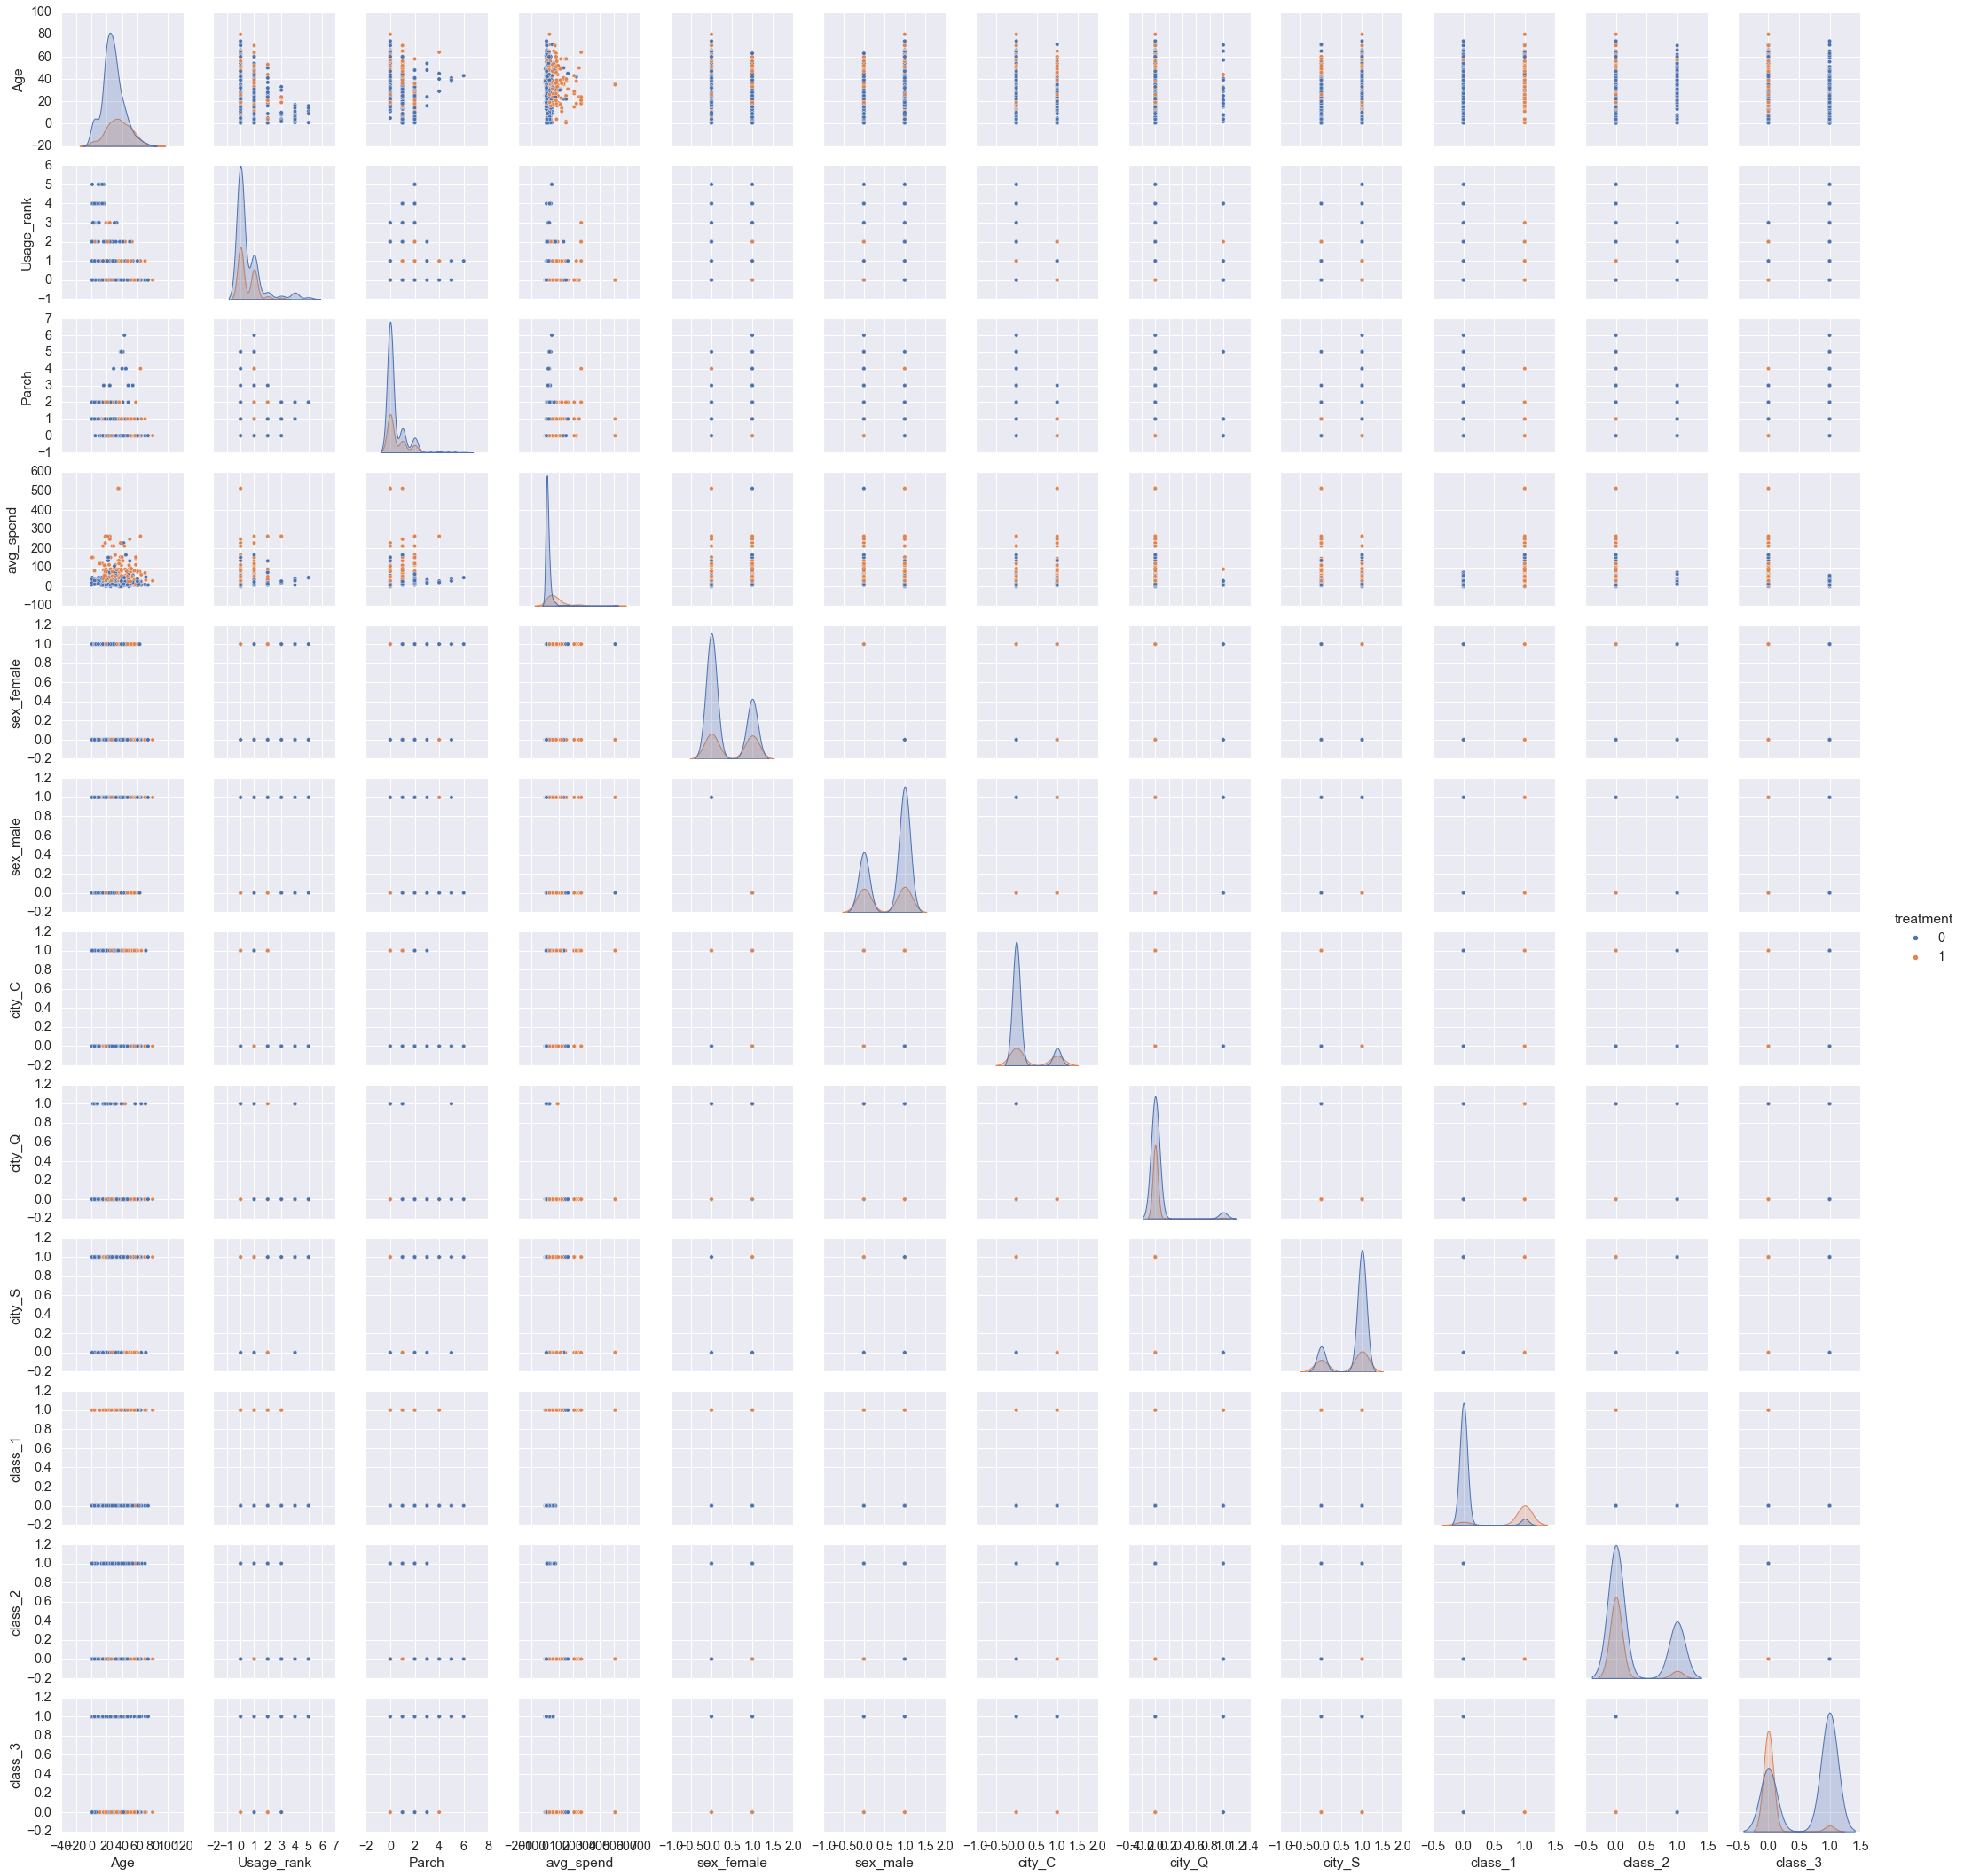

In [69]:
sns.pairplot(data = df_data[cols], hue = 'treatment')
print('Overview before matching')

Overview after matching


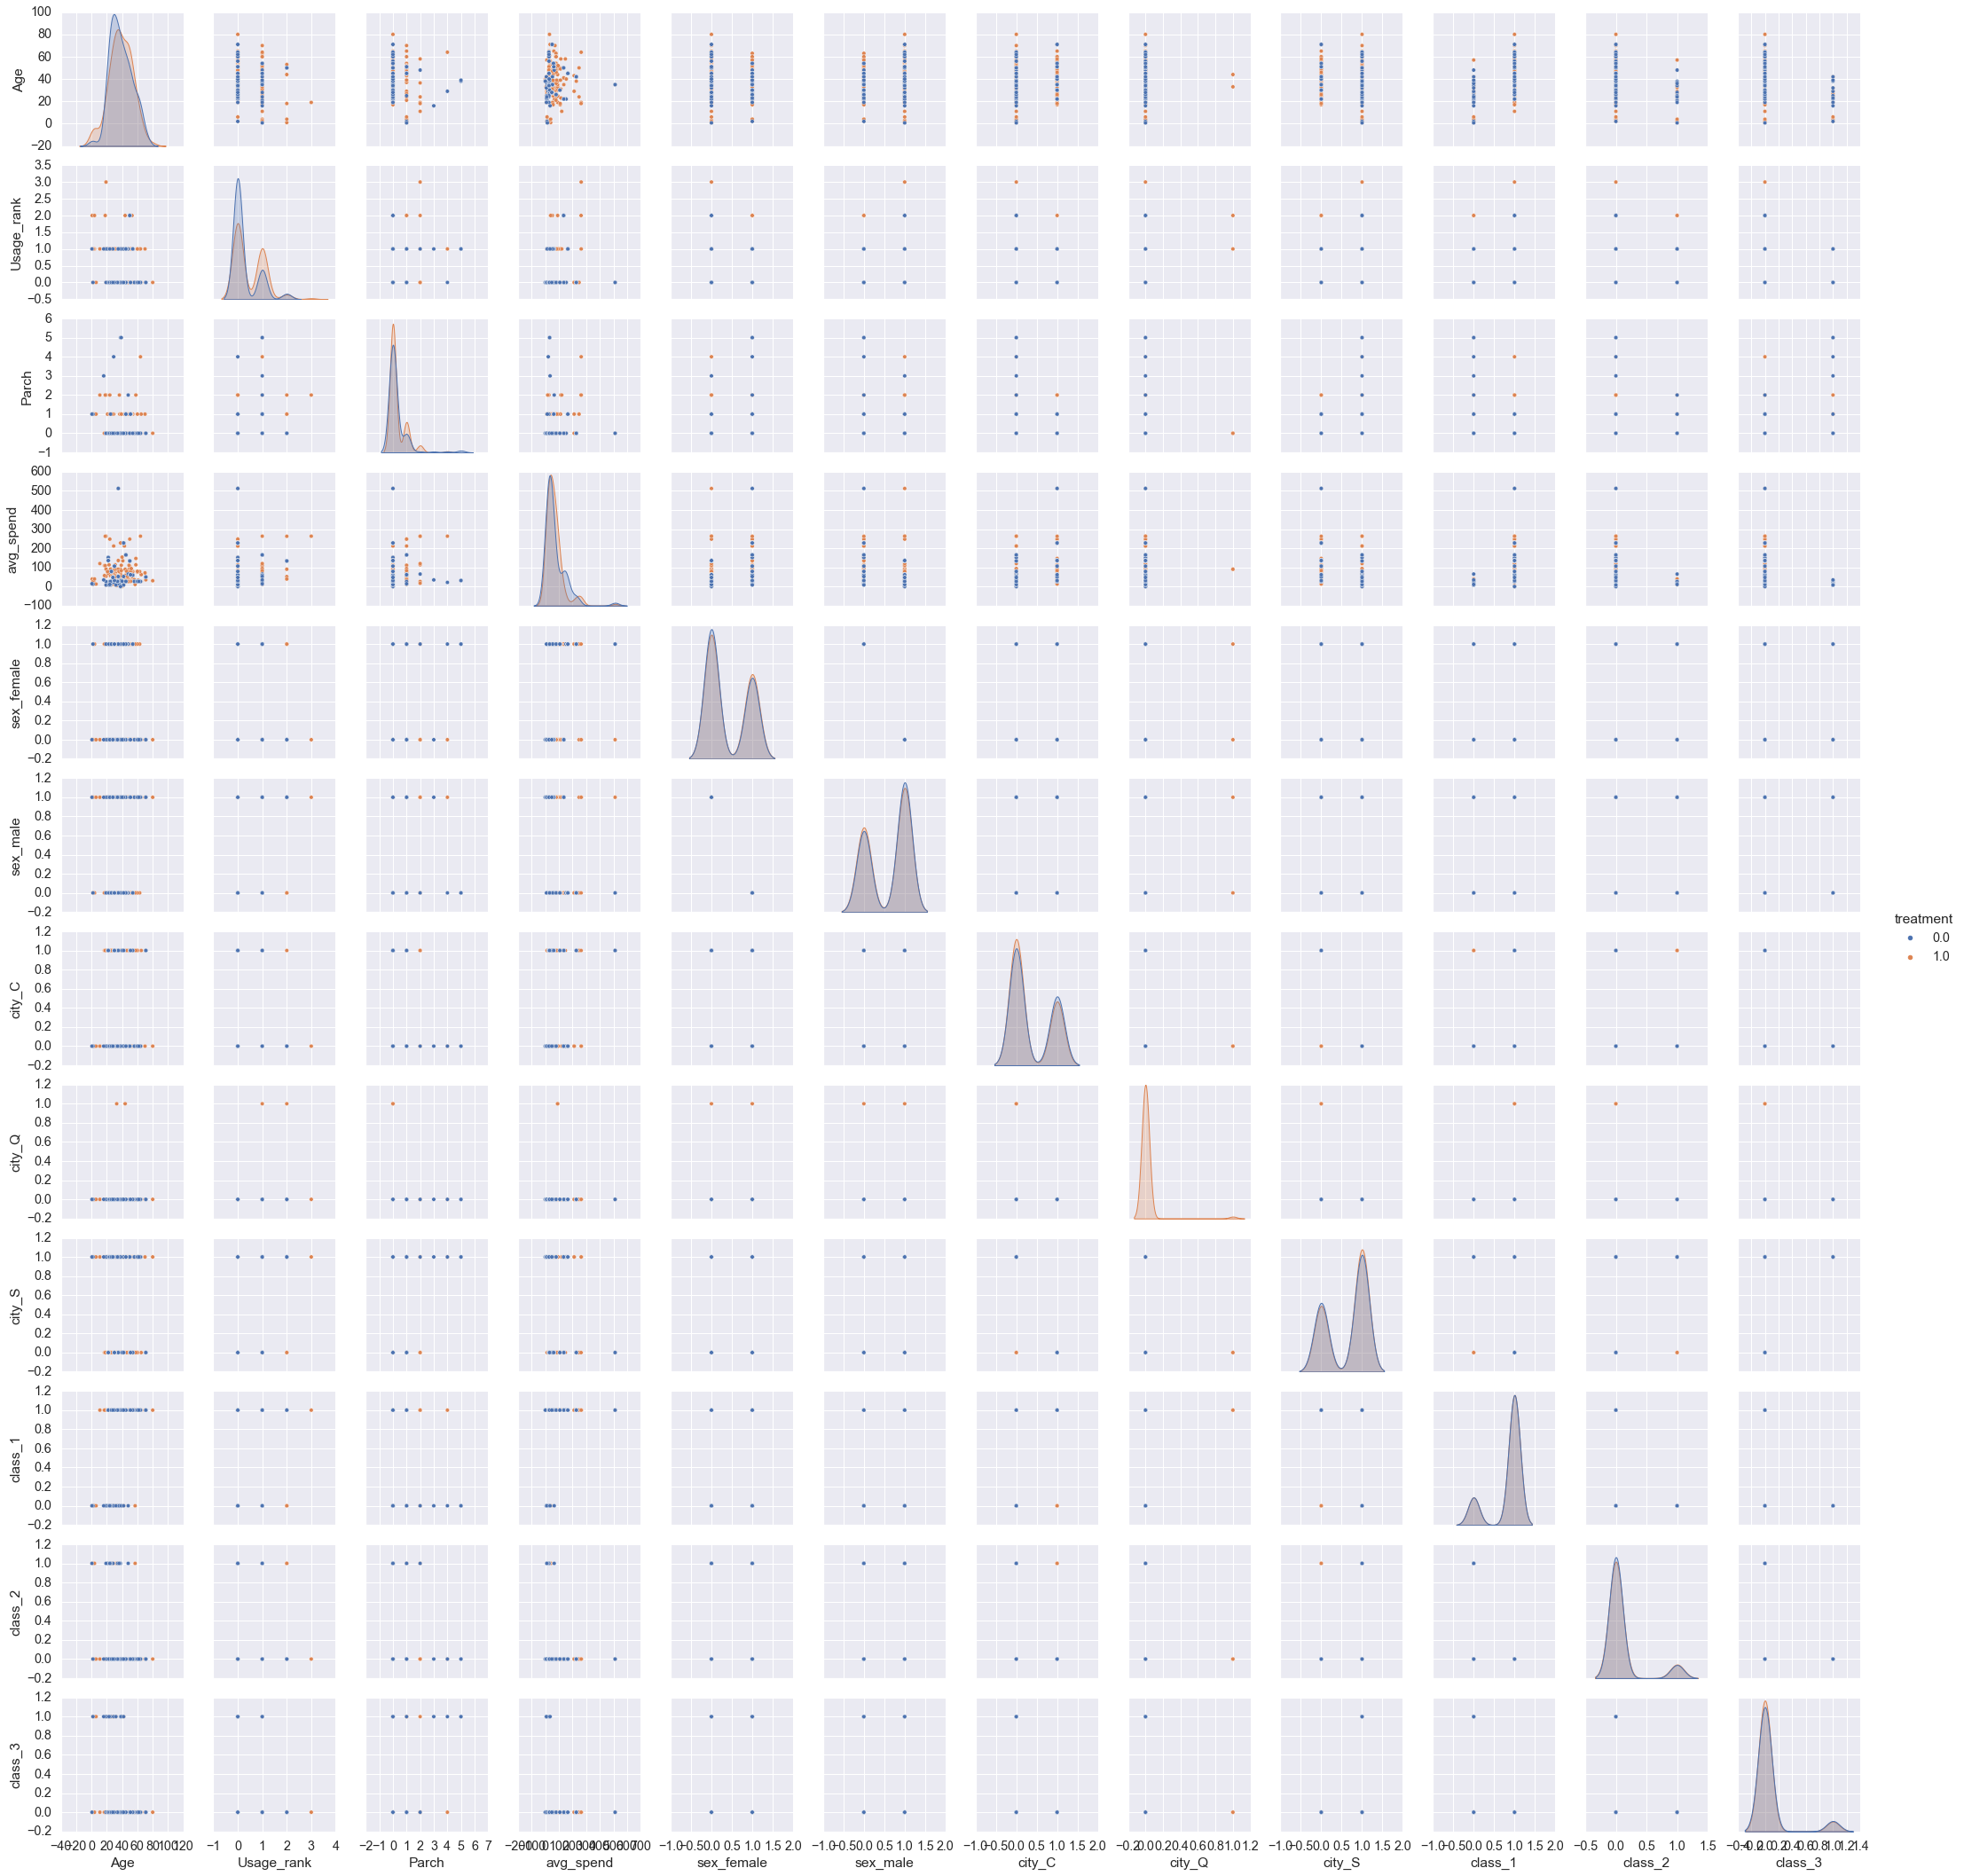

In [70]:
sns.pairplot(data = all_mached_data[cols], hue = 'treatment')
print('Overview after matching')

# Average Treatement effect

In [71]:
overview = all_mached_data[['outcome','treatment']].groupby(by = ['treatment']).aggregate([np.mean, np.var, np.std, 'count'])
print(overview)

            outcome                          
               mean       var       std count
treatment                                    
0.0        0.510490  0.251650  0.501647   143
1.0        0.622378  0.236679  0.486496   143


In [72]:
treated_outcome = overview['outcome']['mean'][1]
treated_counterfactual_outcome = overview['outcome']['mean'][0]

In [73]:
att = treated_outcome - treated_counterfactual_outcome
print('The Average Treatment Effect (ATT): {:.4f}'.format(att))

The Average Treatment Effect (ATT): 0.1119


In [74]:
treated_outcome = treated_matched_data.outcome
untreated_outcome = untreated_matched_data.outcome
# stats_results = stats.ttest_ind(treated_outcome, untreated_outcome)

In [75]:
tmp = pd.DataFrame(data = {'treated_outcome' : treated_outcome.values, 'untreated_outcome' : untreated_outcome.values})

#### Inspired from <a href='https://github.com/konosp'>Konstantinos Papadopoulos</a>